          system_cost           carbon wave_capacity wave_profit
0   3941882178.040016   4592038.009612      0.288255   -0.000001
1    4735399838.31953   9625720.963399      0.218069    0.000002
2   5182651472.167793  12190000.000002      0.127881   -0.000002
3   5435286158.245062  12190000.000002      0.074087    0.000001
4   5530324783.458324  12190000.000002      0.033333   -0.000002
5   4397216686.757848   9646752.630193      0.289583    0.000002
6   5474118029.420002  12190000.000001      0.122283   -0.000001
7   5438061705.703382  12190000.000001      0.081618    0.000006
8   5635645668.810459  12190000.000001      0.032807    0.000002
9   5454108274.658245  12190000.000001           0.0         0.0
10  4899209479.624402  12190000.000001       0.26469         0.0
11  5290086459.908672  12190000.000001       0.13061    0.000001
12  5567538285.481652  12190000.000001      0.051922   -0.000002
13   5665234622.93825  12190000.000001           0.0         0.0
14  5627066231.955829  12

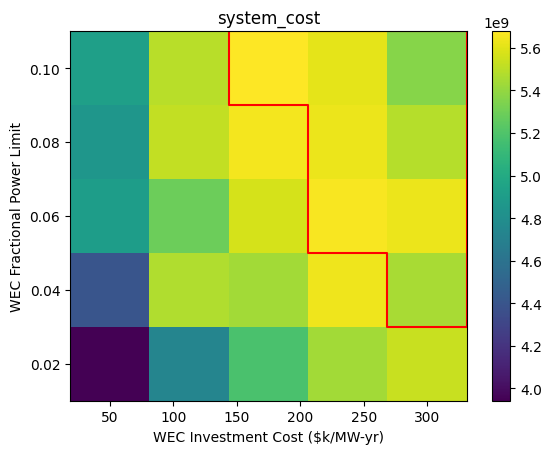

[[4592038.009612141 9625720.963399231 12190000.000001611
  12190000.000001796 12190000.000002032]
 [9646752.630193409 12190000.000001015 12190000.000001185
  12190000.000001036 12190000.00000095]
 [12190000.000001311 12190000.000001203 12190000.000001015
  12190000.00000055 12190000.000001552]
 [12190000.000000568 12190000.00000117 12190000.000001688
  12190000.0000011 12190000.000001114]
 [12190000.000001088 12190000.000002015 12190000.000000764
  12190000.000000892 12190000.000001324]]


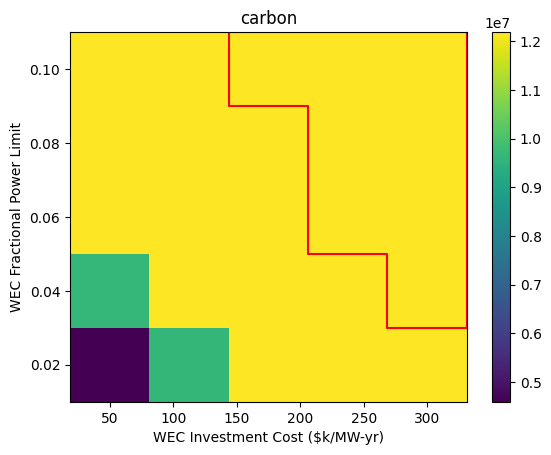

[[0.2882546887626812 0.21806917390523772 0.12788125161902728
  0.07408717961162263 0.03333286272261254]
 [0.28958262939266627 0.12228282241473247 0.0816184734855925
  0.03280663524859195 0.0]
 [0.2646897408732217 0.13061003493054715 0.05192156246187956 0.0 0.0]
 [0.25209795954362374 0.14343132195949845 0.01937366964041034 0.0 0.0]
 [0.25868110336168404 0.08262189068455504 0.0 0.0 0.0]]


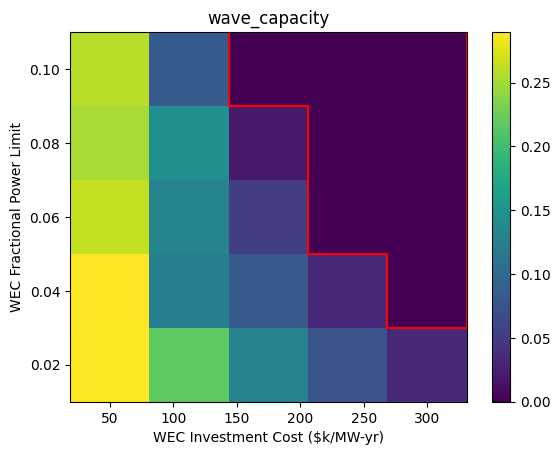

[[-8.344650268554688e-07 2.384185791015625e-06 -1.6689300537109375e-06
  1.430511474609375e-06 -2.3245811462402344e-06]
 [1.6689300537109375e-06 -8.344650268554688e-07 5.602836608886719e-06
  2.026557922363281e-06 0.0]
 [0.0 9.5367431640625e-07 -1.5497207641601562e-06 0.0 0.0]
 [-9.5367431640625e-07 -5.960464477539062e-07 -2.682209014892578e-07 0.0
  0.0]
 [5.960464477539062e-07 1.3113021850585938e-06 0.0 0.0 0.0]]


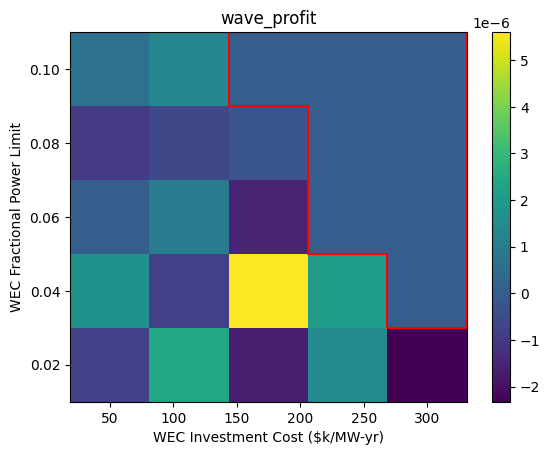

In [78]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

inputs = pd.read_csv('replacements.csv')
output_cols = ['system_cost', 'carbon', 'wave_capacity','wave_profit']
outputs = pd.DataFrame(index=inputs.index, columns=output_cols)

for case in np.arange(1,len(inputs)+1):
    idx = case-1
    result_folder = os.path.join('Cases','case_'+str(case),'Results')
    cost_file     = os.path.join(result_folder,'costs.csv')
    carbon_file   = os.path.join(result_folder,'emissions.csv')
    capacity_file = os.path.join(result_folder,'capacity.csv')
    revenue_file  = os.path.join(result_folder,'NetRevenue.csv')

    system_cost_df   = pd.read_csv(cost_file,     index_col='Costs')
    carbon_df        = pd.read_csv(carbon_file,   index_col='Zone', nrows=3)
    wave_capacity_df = pd.read_csv(capacity_file, index_col='Resource',usecols=['Resource','EndCap'])
    wave_profit_df   = pd.read_csv(revenue_file,  index_col='Resource',usecols=['Resource','Profit'])
    
    system_cost = system_cost_df['Total'].loc['cTotal']
    carbon = carbon_df['Total'].loc['AnnualSum']
    wave_profit = wave_profit_df['Profit'].loc['NENGREST_wave']
    wave_capacity = wave_capacity_df['EndCap'].loc['NENGREST_wave'] / wave_capacity_df['EndCap'].loc['Total']
    outputs.loc[idx] = [system_cost,carbon,wave_capacity,wave_profit]

print(outputs)

square_size = np.sqrt(inputs.waveInvCost.size).astype(int)
square_tuple = (square_size,square_size)

wec_cost  = np.reshape(inputs.waveInvCost.values, square_tuple)
power_lim = np.reshape(inputs.Notes.values,       square_tuple)

# hardcoded based on result - in the future do this programatically
x = 250/8
points = np.array([[300+x,   0.03],
                   [300-x,   0.03],
                   [300-x,   0.05],
                   [300-3*x, 0.05],
                   [300-3*x, 0.09],
                   [300-5*x, 0.09],
                   [300-5*x, 0.11],
                   [300+x,   0.11],
                   [300+x,   0.03]])

for output in output_cols:
    output_reshaped = np.reshape(outputs[output].values, square_tuple)
    fig, ax = plt.subplots()
    print(output_reshaped)
    plt.pcolormesh(wec_cost/1000,power_lim,output_reshaped.astype(float))
    plt.plot(points[:,0],points[:,1],'r')
    plt.title(output)
    plt.xlabel('WEC Investment Cost ($k/MW-yr)')
    plt.ylabel('WEC Fractional Power Limit')
    plt.colorbar()
    plt.show()